# Power and Connected UEs over Time

This notebook loads:
- Power per PCI over time from `cell_power_changes.csv` and computes a Total Power across PCIs.
- Connected UEs over time from `input.csv`.

It then aligns both series on a common time axis and plots them with dual y-axes.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Seaborn style to match Plot3
sns.set_theme(style="whitegrid")

# File paths
base = Path('/home/vmadmin/Energy-Saver-Tests/results/energy-over-time')
file_power = base / 'cell_power_changes_20250819_040811.csv'
file_ues = base / 'input_after_14.csv'

file_power, file_ues

(PosixPath('/home/vmadmin/Energy-Saver-Tests/results/energy-over-time/cell_power_changes_20250819_040811.csv'),
 PosixPath('/home/vmadmin/Energy-Saver-Tests/results/energy-over-time/input_after_14.csv'))

In [2]:
# Load data
power_df = pd.read_csv(file_power)
ues_df = pd.read_csv(file_ues)

# Inspect and normalize column names
power_df.columns = [c.strip() for c in power_df.columns]
ues_df.columns = [c.strip() for c in ues_df.columns]

# Rename time columns for consistency
if 'Time(h)' in power_df.columns:
    power_df = power_df.rename(columns={'Time(h)': 'time_h'})
if 'Time(h)' in ues_df.columns:
    ues_df = ues_df.rename(columns={'Time(h)': 'time_h'})

# Compute total power across all PCI columns
pci_cols = [c for c in power_df.columns if c.startswith('pci_')]
power_df['total_power'] = power_df[pci_cols].sum(axis=1, skipna=True)

# Keep only time and total power
power_df = power_df[['time_h', 'total_power']].sort_values('time_h').reset_index(drop=True)

# Keep only time and connected UEs
ue_col_candidates = [c for c in ues_df.columns if 'UE' in c or 'Connected' in c]
ue_col = ue_col_candidates[0] if ue_col_candidates else ues_df.columns[1]
ues_df = ues_df[['time_h', ue_col]].rename(columns={ue_col: 'connected_ues'})
ues_df = ues_df.sort_values('time_h').reset_index(drop=True)

power_df.head(), ues_df.head(), ue_col

(     time_h  total_power
 0  0.056681       1130.0
 1  0.056686       1129.0
 2  0.062836       1109.0
 3  0.062837       1089.0
 4  0.062839       1069.0,
      time_h  connected_ues
 0  0.107969     782.918149
 1  0.251928     939.501779
 2  0.457584    1266.903915
 3  0.724936     939.501779
 4  0.971722     953.736655,
 'Connected UEs')

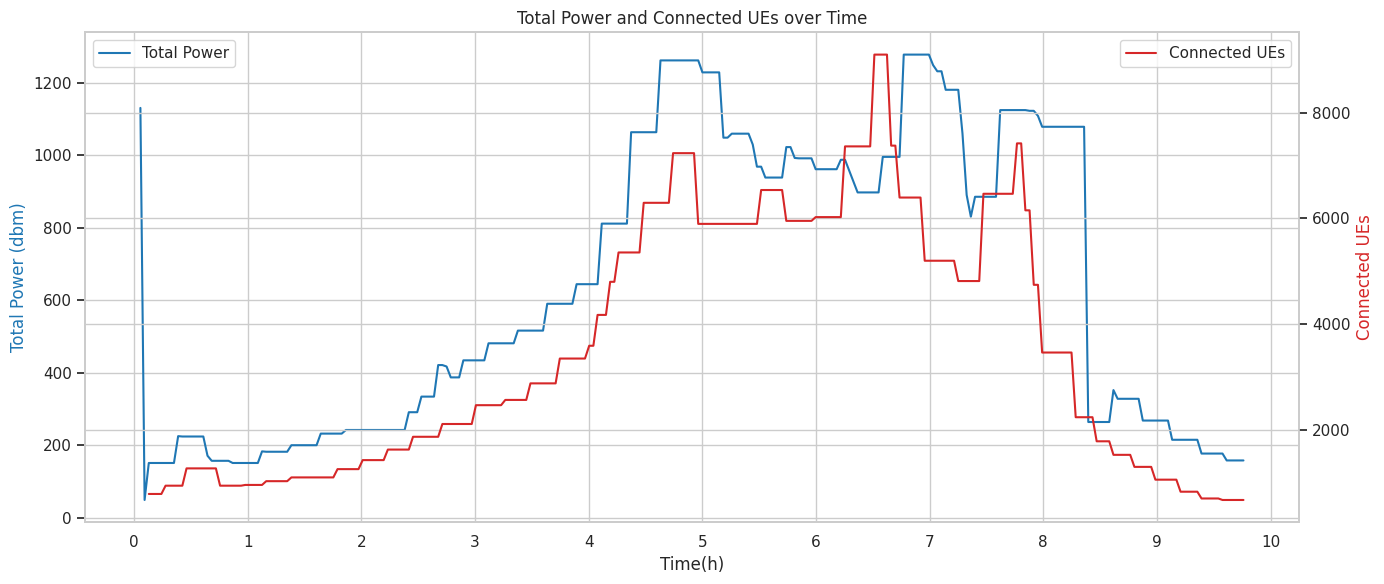

In [3]:
# Align on time
# We'll do an asof merge to interpolate UEs at power timestamps (or vice versa)
# Create uniformly sampled time axis covering both ranges
min_t = min(power_df['time_h'].min(), ues_df['time_h'].min())
max_t = max(power_df['time_h'].max(), ues_df['time_h'].max())

# Resolution: choose the finer of the two mean spacings
power_dt = np.diff(power_df['time_h']).mean() if len(power_df) > 1 else 0.01
ues_dt = np.diff(ues_df['time_h']).mean() if len(ues_df) > 1 else 0.01
step = max(min(power_dt, ues_dt), 0.001)

grid = pd.DataFrame({'time_h': np.arange(min_t, max_t + step/2, step)})

# Interpolate each series onto the grid
power_grid = pd.merge_asof(grid, power_df.sort_values('time_h'), on='time_h')
ues_grid = pd.merge_asof(grid, ues_df.sort_values('time_h'), on='time_h')

merged = grid.join(power_grid[['total_power']], how='left')
merged = merged.join(ues_grid[['connected_ues']], how='left')

# Optional: linear interpolation for smoother plots
merged['total_power'] = merged['total_power'].interpolate()
merged['connected_ues'] = merged['connected_ues'].interpolate()

# Plot with seaborn/matplotlib (style like Plot3)
plt.figure(figsize=(14, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

sns.lineplot(data=merged, x='time_h', y='total_power', ax=ax1, color='tab:blue', label='Total Power')
sns.lineplot(data=merged, x='time_h', y='connected_ues', ax=ax2, color='tab:red', label='Connected UEs')

ax1.set_xlabel('Time(h)')
# Integer ticks like Plot3
try:
    xmin, xmax = float(merged['time_h'].min()), float(merged['time_h'].max())
    ax1.set_xticks(np.arange(int(np.floor(xmin)), int(np.ceil(xmax)) + 1, 1))
except Exception:
    pass

ax1.set_ylabel('Total Power (dbm)', color='tab:blue')
ax2.set_ylabel('Connected UEs', color='tab:red')
plt.title('Total Power and Connected UEs over Time')

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='upper left')

plt.tight_layout()
# Save like Plot3
out_dir = base / 'out'
out_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(out_dir / 'power_vs_ues.png', bbox_inches='tight')
plt.savefig(out_dir / 'power_vs_ues.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Notes
- X-axis is hours from the CSVs.
- Total Power is the sum across all `pci_*` columns.
- Connected UEs is taken from the `Connected UEs` column of `input.csv`.
- The series are interpolated onto a common grid for a smooth comparison.